Notes for Chapter 3: https://d2l.ai/chapter_linear-regression/index.html 

### 3.1. Linear regression

#### 3.1.1. Basics

$\hat y = w_1 x_1 + \ldots + w_d x_d + b$

$\hat y = \textbf w^T \textbf x + b$

w is (2,1), x is (2,1) (only one observation)

It is often better to represent in matrix/vector form. 

$\hat {\textbf y} = \textbf {X}^T\textbf{w} + b$

$\hat {\textbf y} \in \mathbb{R}^{n\times 1}, \mathbf X \in \mathbb{R}^{n\times d}, \textbf w \in \mathbb{R}^{d\times 1}, b \in \mathbb{R}^{1\times 1}$, and $n$ is the number of observations, while $d$ is the number of features

#### 3.1.1.2. Loss function

$l^{(i)}(\textbf w, b) = \frac{1}{2}\left( \hat y ^{(i)} - y^{(i)}  \right)^2$

$L(\textbf w, b) = \frac{1}{n} \sum_{i=1}^n l^{(i)}(\textbf w, b) = \frac{1}{n} \sum_{i=1}^n  \frac{1}{2}\left( \textbf w^T \textbf x^{(i)} + b - y^{(i)}  \right)^2$

When training the model, we seek:

$\textbf w^*, b^* = \argmin_{\textbf w, b} L(\textbf w, b)$

#### 3.1.1.3. Analytic Solution

we can solve this by taking the bias into the parameter $\textbf w$ by appending a column of ones in the design matrix $\textbf W$. Our problem then is to minimize $||\textbf~y~-~\textbf{Xw}||^2$... this leads to solving: 

$$\textbf w^* = (\textbf{X}^T\textbf{X})^{-1} \textbf{X}^T \textbf{y}$$

#### 3.1.2. Vectorization for speed

In [2]:
# %matplotlib inline
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l


this example shows how using the vectoriz functions is significantly faster than using a loop. 

In [4]:
n = 10000
a = tf.ones(n)
b = tf.ones(n)

In [7]:
c = tf.Variable(tf.zeros(n))
t = time.time()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{time.time() - t:.5f} sec'

'9.38135 sec'

In [8]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00116 sec'

#### 3.1.3. Normal dist with squared loss

In [9]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

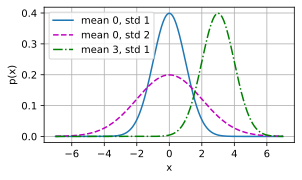

In [10]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

#### 3.1.4. linear regression as a neural network

### 3.2. Object oriented design

In [15]:
import time
import numpy as np
import tensorflow as tf
from d2l import torch as d2l


In [16]:
def add_to_class(Class):  #@save
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [20]:
class A:
    def __init__(self):
        self.b = 1

a = A()

In [21]:
a.b

1

In [23]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1
